# Problem Statement

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, we have to predict the final price of each home.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


## Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats

## Concatinating train and test data[](http://)

In [3]:
train = pd.read_csv(r'/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv(r'/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
df = pd.concat([train,test])
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


## Exploring Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [6]:
df.shape

(2919, 81)

## Finding Missing Values

In [7]:
df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 81, dtype: int64

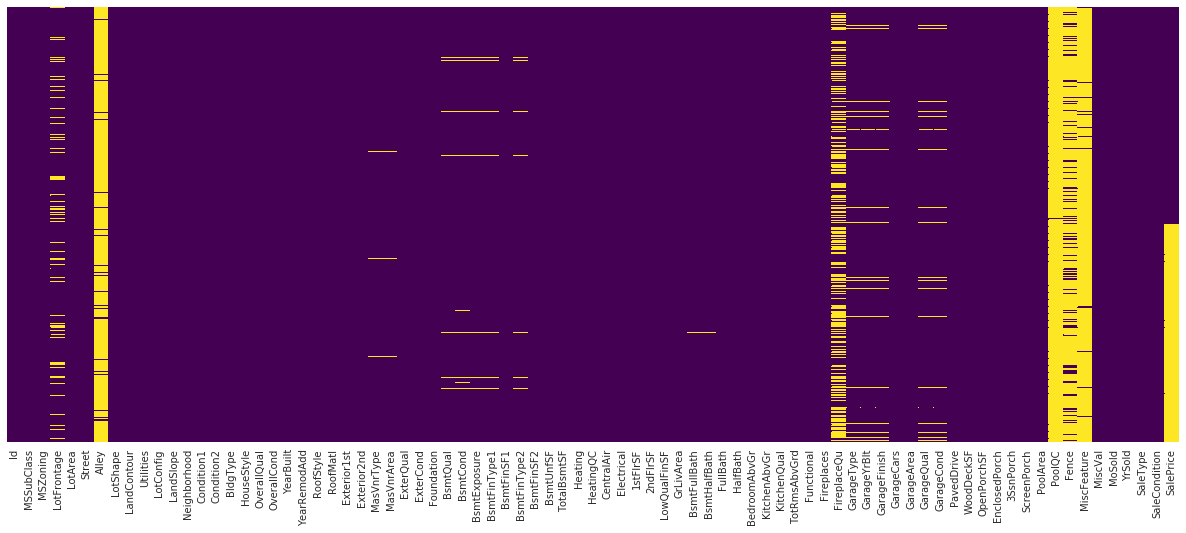

In [8]:
plt.figure(figsize=(21,8))
sns.set_style('whitegrid')
sns.heatmap(df.isnull(), cmap = 'viridis', yticklabels = False, cbar = False)

In [9]:
feature_with_na_values = [feature for feature in df.columns if df[feature].isnull().sum()>1]
for feature in feature_with_na_values:
    print(feature, np.round(df[feature].isnull().mean(),4), '% of missing value')

MSZoning 0.0014 % of missing value
LotFrontage 0.1665 % of missing value
Alley 0.9322 % of missing value
Utilities 0.0007 % of missing value
MasVnrType 0.0082 % of missing value
MasVnrArea 0.0079 % of missing value
BsmtQual 0.0277 % of missing value
BsmtCond 0.0281 % of missing value
BsmtExposure 0.0281 % of missing value
BsmtFinType1 0.0271 % of missing value
BsmtFinType2 0.0274 % of missing value
BsmtFullBath 0.0007 % of missing value
BsmtHalfBath 0.0007 % of missing value
Functional 0.0007 % of missing value
FireplaceQu 0.4865 % of missing value
GarageType 0.0538 % of missing value
GarageYrBlt 0.0545 % of missing value
GarageFinish 0.0545 % of missing value
GarageQual 0.0545 % of missing value
GarageCond 0.0545 % of missing value
PoolQC 0.9966 % of missing value
Fence 0.8044 % of missing value
MiscFeature 0.964 % of missing value
SalePrice 0.4998 % of missing value


### Removing variables have greater than 70% of missing values

In [10]:
df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)
df.shape

(2919, 77)

### Treating categorical and numerical features differently

In [11]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
len(categorical_features)

39

In [12]:
numerical_features = [feature for feature in df.columns if feature not in categorical_features]
len(numerical_features)

38

In [13]:
categorical_feature_with_na_values = [feature for feature in categorical_features if df[feature].isnull().sum()>1]
len(categorical_feature_with_na_values)

14

In [14]:
numerical_feature_with_na_values = [feature for feature in numerical_features if df[feature].isnull().sum()>1]
len(numerical_feature_with_na_values)

6

## Filling the missing values

In [15]:
for feature in categorical_feature_with_na_values:
    df[feature] = df[feature].fillna(df[feature].mode()[0])

In [16]:
for feature in numerical_feature_with_na_values:
    df[feature] = df[feature].fillna(df[feature].mean())

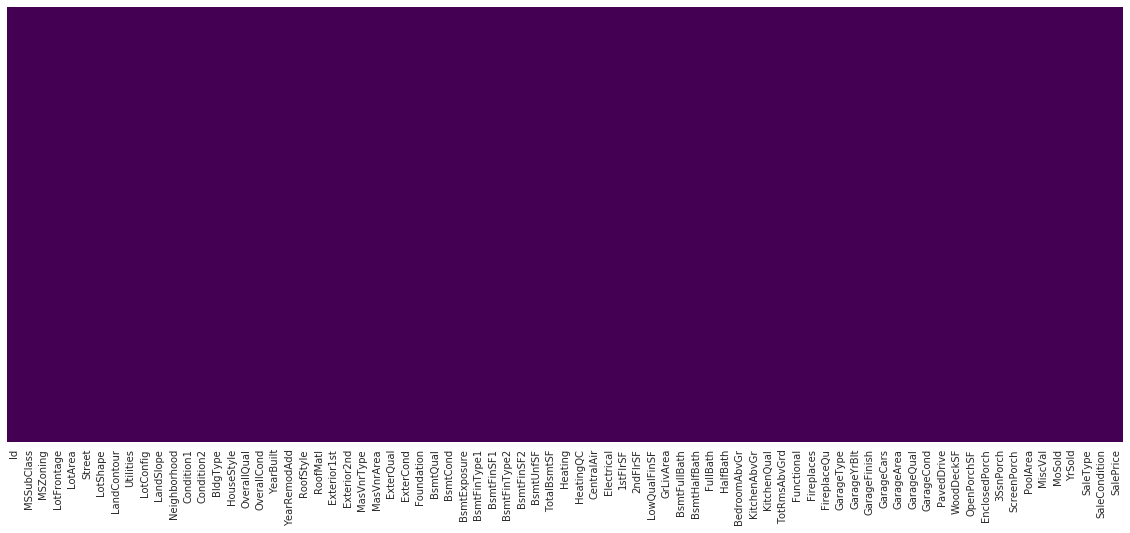

In [17]:
plt.figure(figsize=(20,8))
sns.set_style('whitegrid')
sns.heatmap(df.isnull(), cmap = 'viridis', yticklabels = False, cbar = False)

## Label Encoding the categorical variables

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for feature in categorical_features:
    df[feature] = le.fit_transform(df[feature].astype('str'))

### Dealing with features containing Years

As YearSold feature doesn't impact on SalePrice but the difference between the other features containg years data and YearSold will have huge impact. So, we changed our features according to that

In [19]:
year_features = [feature for feature in df.columns if 'Yr' in feature or 'Year' in feature]
print(year_features)

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']


In [20]:
for feature in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    df[feature] = (df['YrSold'] - df[feature]).astype('int')
df[year_features].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,5,5,5,2008
1,31,31,31,2007
2,7,6,7,2008
3,91,36,8,2006
4,8,8,8,2008


In [21]:
df.drop('YrSold',axis=1,inplace=True)
df.shape

(2919, 76)

In [22]:
print(categorical_features)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


## Getting test and train data back

In [23]:
df.sort_values(by = 'Id',)
train_df = df.iloc[:1460,:]
test_df = df.iloc[1460:,:]
print('Shape of Train Data :' + str(train_df.shape))
print('Shape of Test Data :' + str(test_df.shape))

Shape of Train Data :(1460, 76)
Shape of Test Data :(1459, 76)


In [24]:
test_df.drop('SalePrice', inplace = True, axis = 1)
test_df.shape

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(1459, 75)

In [25]:
print(numerical_features)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


## Plotting ScatterPlot between numerical features and SalePrice 

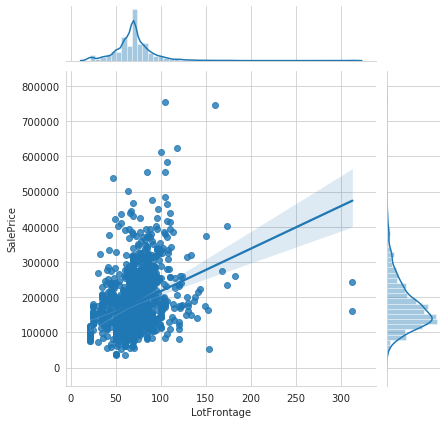

In [26]:
sns.jointplot(train_df['LotFrontage'], train_df['SalePrice'], kind = 'reg')

### Detecting outliers and eliminating them

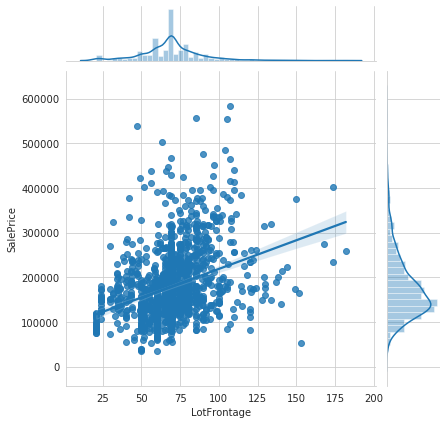

In [27]:
train_df = train_df.drop(train_df[(train_df['LotFrontage']>200) & (train_df['SalePrice']<300000)].index).reset_index(drop=True)
train_df = train_df.drop(train_df[(train_df['LotFrontage']<200) & (train_df['SalePrice']>600000)].index).reset_index(drop=True)
sns.jointplot(train_df['LotFrontage'], train_df['SalePrice'], kind = 'reg')

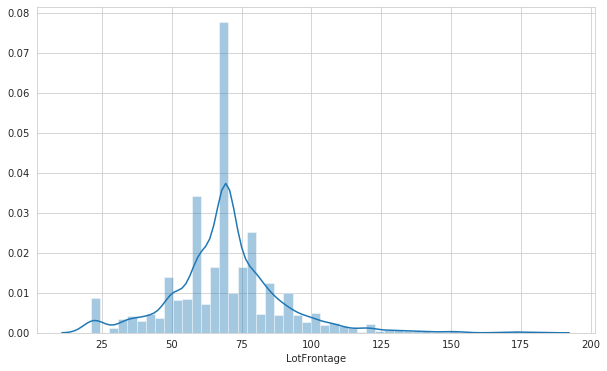

In [28]:
plt.figure(figsize=(10,6))
sns.distplot(train_df['LotFrontage'])

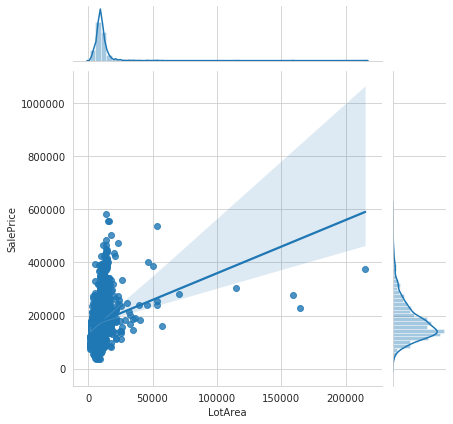

In [29]:
sns.jointplot(train_df['LotArea'], train_df['SalePrice'], kind = 'reg')

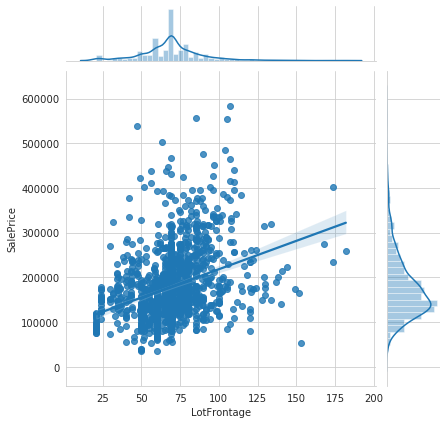

In [30]:
train_df = train_df.drop(train_df[(train_df['LotArea']>100000) & (train_df['SalePrice']<400000)].index).reset_index(drop=True)
sns.jointplot(train_df['LotFrontage'], train_df['SalePrice'], kind = 'reg')

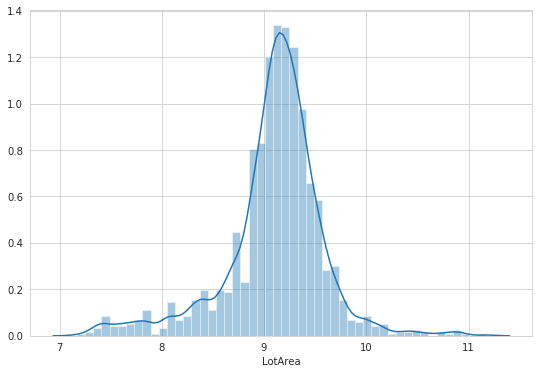

In [31]:
train_df['LotArea'] = np.log(train_df['LotArea'])
plt.figure(figsize=(9,6))
sns.distplot(train_df['LotArea'])

## Tranformation of Features 

In [32]:
test_df['LotArea'] = np.log(test_df['LotArea'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


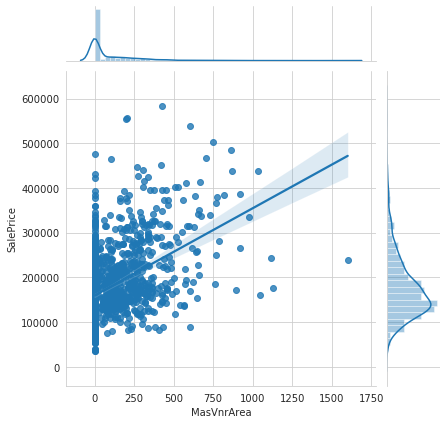

In [33]:
sns.jointplot(train_df['MasVnrArea'], train_df['SalePrice'], kind = 'reg')

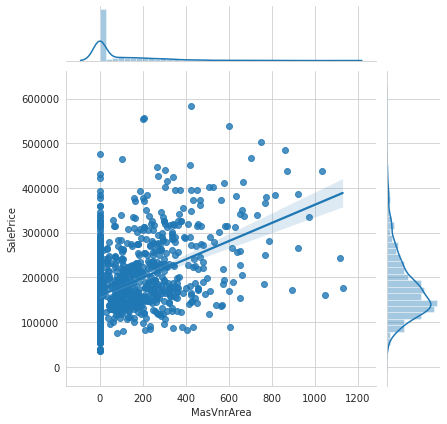

In [34]:
train_df = train_df.drop(train_df[(train_df['MasVnrArea']>1500) & (train_df['SalePrice']<300000)].index).reset_index(drop=True)
sns.jointplot(train_df['MasVnrArea'], train_df['SalePrice'], kind = 'reg')

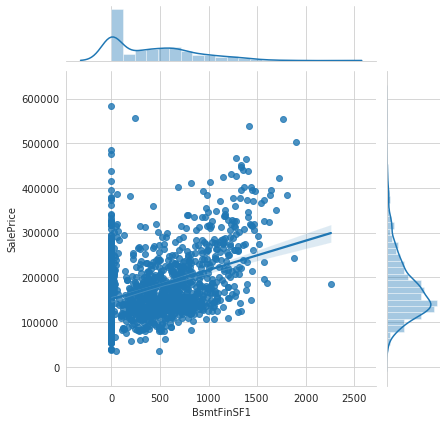

In [35]:
sns.jointplot(train_df['BsmtFinSF1'], train_df['SalePrice'], kind = 'reg')

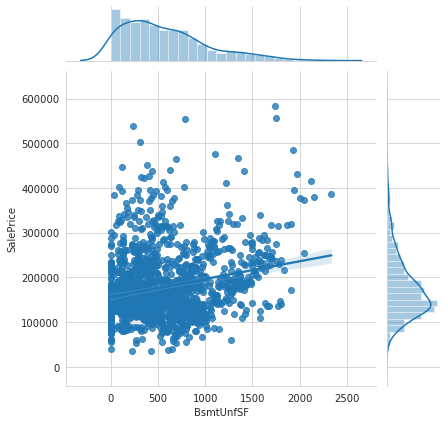

In [36]:
sns.jointplot(train_df['BsmtUnfSF'], train_df['SalePrice'], kind = 'reg')

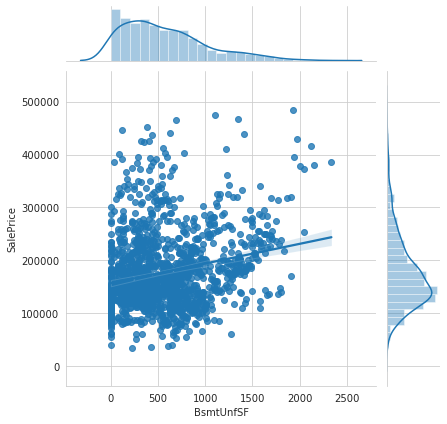

In [37]:
train_df = train_df.drop(train_df[(train_df['BsmtUnfSF']<2000) & (train_df['SalePrice']>500000)].index).reset_index(drop=True)
sns.jointplot(train_df['BsmtUnfSF'], train_df['SalePrice'], kind = 'reg')

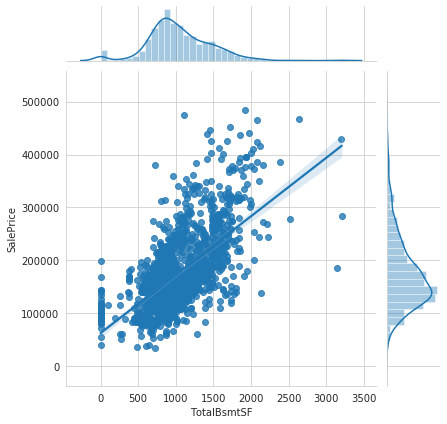

In [38]:
sns.jointplot(train_df['TotalBsmtSF'], train_df['SalePrice'], kind = 'reg')

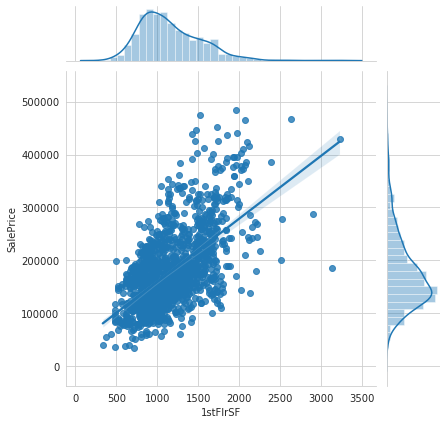

In [39]:
sns.jointplot(train_df['1stFlrSF'], train_df['SalePrice'], kind = 'reg')

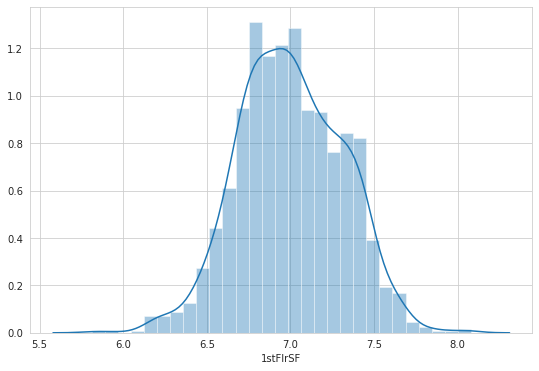

In [40]:
train_df['1stFlrSF'] = np.log(train_df['1stFlrSF'])
plt.figure(figsize=(9,6))
sns.distplot(train_df['1stFlrSF'])

In [41]:
test_df['1stFlrSF'] = np.log(test_df['1stFlrSF'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


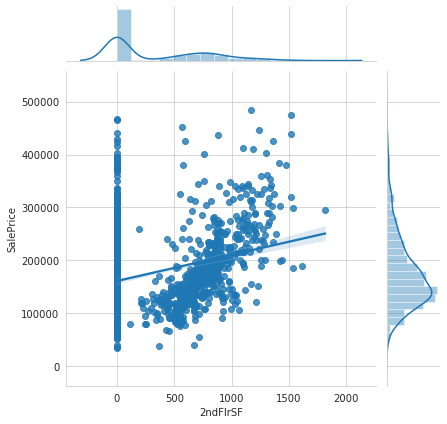

In [42]:
sns.jointplot(train_df['2ndFlrSF'], train_df['SalePrice'], kind = 'reg')

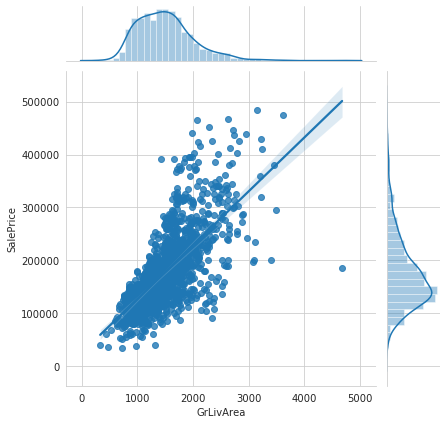

In [43]:
sns.jointplot(train_df['GrLivArea'], train_df['SalePrice'], kind = 'reg')

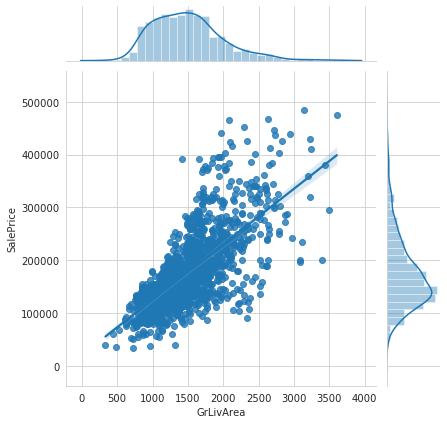

In [44]:
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<200000)].index).reset_index(drop=True)
sns.jointplot(train_df['GrLivArea'], train_df['SalePrice'], kind = 'reg')

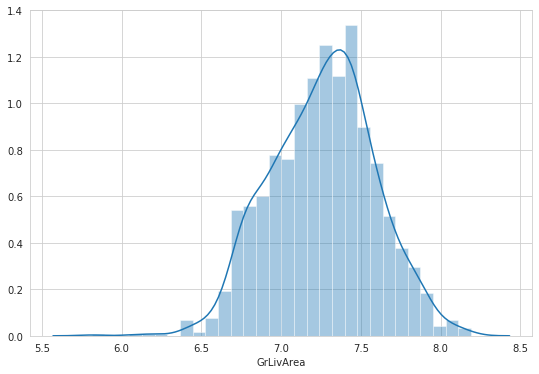

In [45]:
train_df['GrLivArea'] = np.log(train_df['GrLivArea'])
plt.figure(figsize=(9,6))
sns.distplot(train_df['GrLivArea'])

In [46]:
test_df['GrLivArea'] = np.log(test_df['GrLivArea'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


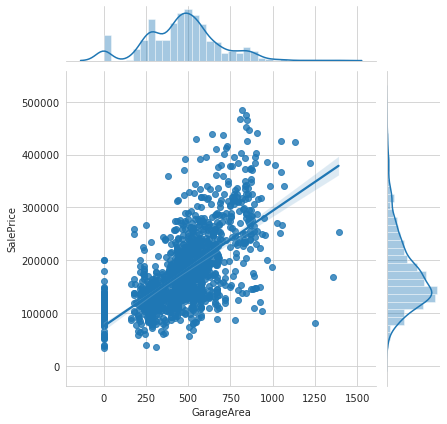

In [47]:
sns.jointplot(train_df['GarageArea'], train_df['SalePrice'], kind = 'reg')

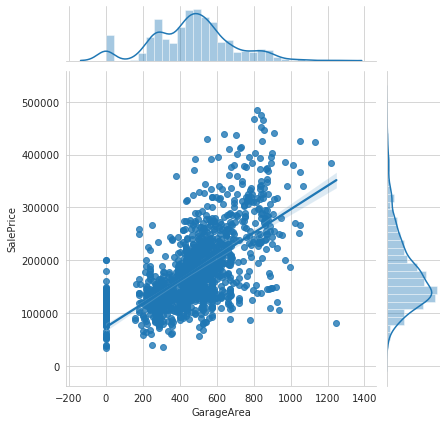

In [48]:
train_df = train_df.drop(train_df[(train_df['GarageArea']>=1250) & (train_df['SalePrice']<300000)].index).reset_index(drop=True)
sns.jointplot(train_df['GarageArea'], train_df['SalePrice'], kind = 'reg')

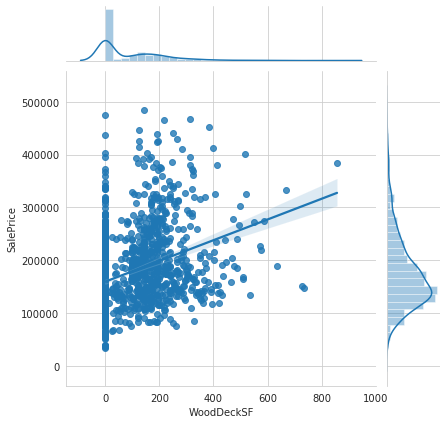

In [49]:
sns.jointplot(train_df['WoodDeckSF'], train_df['SalePrice'], kind = 'reg')

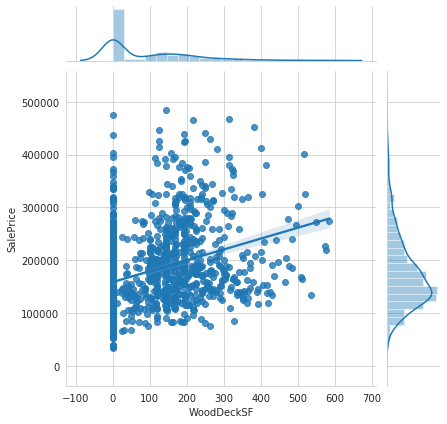

In [50]:
train_df = train_df.drop(train_df[(train_df['WoodDeckSF']>=600) & (train_df['SalePrice']<400000)].index).reset_index(drop=True)
sns.jointplot(train_df['WoodDeckSF'], train_df['SalePrice'], kind = 'reg')

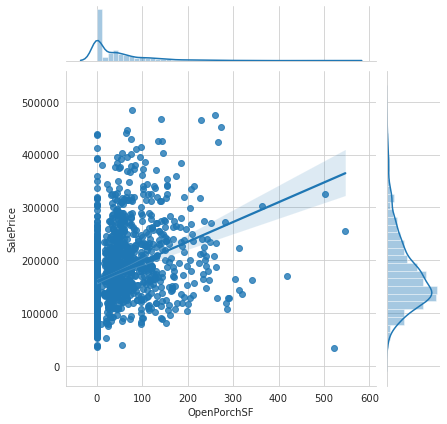

In [51]:
sns.jointplot(train_df['OpenPorchSF'], train_df['SalePrice'], kind = 'reg')

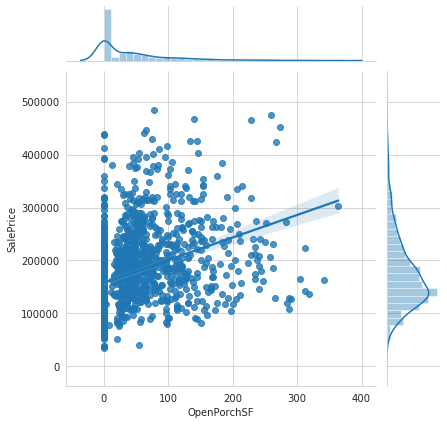

In [52]:
train_df = train_df.drop(train_df[(train_df['OpenPorchSF']>=400) & (train_df['SalePrice']<400000)].index).reset_index(drop=True)
sns.jointplot(train_df['OpenPorchSF'], train_df['SalePrice'], kind = 'reg')

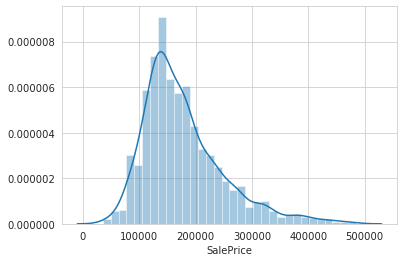

In [53]:
sns.distplot(train_df['SalePrice'])

In [54]:
print(train_df.shape)
print(test_df.shape)

(1432, 76)
(1459, 75)


In [55]:
categorical_feature = [feature for feature in df.columns if df[feature].dtype == 'O']
len(categorical_features)

39

In [56]:
numerical_feature = [feature for feature in df.columns if feature not in categorical_features]
len(numerical_feature)

37

Text(0.5, 1, 'Correlation between Numerical Features')

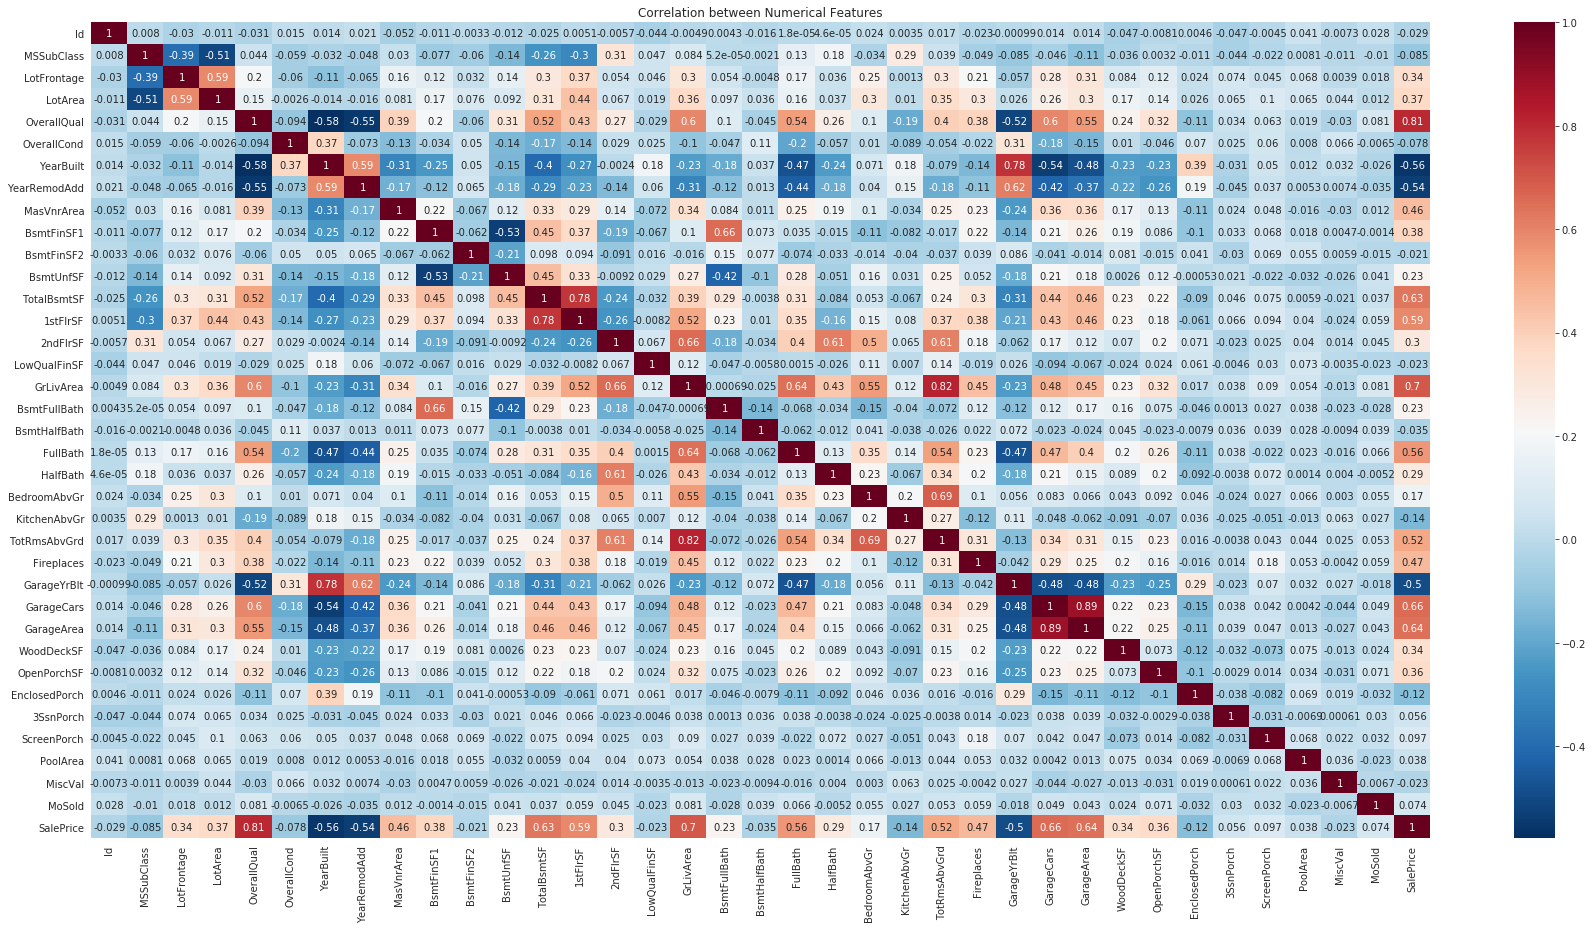

In [59]:
plt.figure(figsize = (30,15))
corr_train_df = train_df[numerical_feature].corr()
sns.heatmap(corr_train_df, cmap = plt.cm.RdBu_r, annot = True)
plt.title('Correlation between Numerical Features')

In [60]:
print("Top 20 Numeric Columns which are highly correlated to SalePrice are:")
print(corr_train_df.nlargest(20, 'SalePrice')['SalePrice'])

Top 20 Numeric Columns which are highly correlated to SalePrice are:
SalePrice       1.000000
OverallQual     0.808274
GrLivArea       0.700697
GarageCars      0.656632
GarageArea      0.643087
TotalBsmtSF     0.633133
1stFlrSF        0.590176
FullBath        0.560118
TotRmsAbvGrd    0.516716
Fireplaces      0.466413
MasVnrArea      0.457552
BsmtFinSF1      0.378791
LotArea         0.369937
OpenPorchSF     0.363655
LotFrontage     0.341374
WoodDeckSF      0.338321
2ndFlrSF        0.295273
HalfBath        0.286342
BsmtFullBath    0.233540
BsmtUnfSF       0.225020
Name: SalePrice, dtype: float64


## Pearson Correlation Between Variables

In [61]:
feat = []
for feature in numerical_feature:
    r, p_value = stats.pearsonr(train_df['SalePrice'], train_df[feature])
    if r>0.1:
        print( feature, "r value:", r, 'and p-value:', p_value)
        feat.append(feature)

LotFrontage r value: 0.34137386306839257 and p-value: 2.0591550522395627e-40
LotArea r value: 0.36993709176345985 and p-value: 1.134020055196042e-47
OverallQual r value: 0.8082741025230854 and p-value: 0.0
MasVnrArea r value: 0.45755230724247636 and p-value: 5.245158100170507e-75
BsmtFinSF1 r value: 0.37879145537902925 and p-value: 4.469376257013707e-50
BsmtUnfSF r value: 0.22501971862988174 and p-value: 6.785507200452433e-18
TotalBsmtSF r value: 0.6331329980586666 and p-value: 2.859863844478344e-161
1stFlrSF r value: 0.5901758086726245 and p-value: 3.9192511807964563e-135
2ndFlrSF r value: 0.29527303666470783 and p-value: 3.342993447577065e-30
GrLivArea r value: 0.7006973721255195 and p-value: 6.247622127971222e-212
BsmtFullBath r value: 0.23353960379862204 and p-value: 3.430381108995669e-19
FullBath r value: 0.5601176369596264 and p-value: 4.660060730907812e-119
HalfBath r value: 0.2863419059918125 and p-value: 1.992087357643407e-28
BedroomAbvGr r value: 0.1712935529663657 and p-valu

In [63]:
for feature in categorical_features:
    r, p_value = stats.pearsonr(train_df['SalePrice'], train_df[feature])
    if r>0.1:
        print( feature, "r value:", r, 'and p-value:', p_value)
        feat.append(feature)

Neighborhood r value: 0.1977826104550511 and p-value: 4.265375431167654e-14
Condition1 r value: 0.10683458402046389 and p-value: 5.102577076234681e-05
HouseStyle r value: 0.18611105213898768 and p-value: 1.2590920895738493e-12
RoofStyle r value: 0.19399662104959461 and p-value: 1.3092932481866238e-13
Exterior1st r value: 0.12118497902390515 and p-value: 4.249144105773816e-06
Exterior2nd r value: 0.12330237233953603 and p-value: 2.8719143597348245e-06
ExterCond r value: 0.138093458198191 and p-value: 1.55191062135312e-07
Foundation r value: 0.4059465650060734 and p-value: 6.2682589606255116e-58
CentralAir r value: 0.26563562902872656 and p-value: 1.4911125522770405e-24
Electrical r value: 0.24527606454119968 and p-value: 4.6064564471613534e-21
Functional r value: 0.1263345890399544 and p-value: 1.6204544246165867e-06
GarageQual r value: 0.11062561435504967 and p-value: 2.7227384224014156e-05
GarageCond r value: 0.14254180309127212 and p-value: 6.060497704534804e-08
PavedDrive r value: 0

In [64]:
feat.remove('SalePrice')
print( feat , len(feat))

['LotFrontage', 'LotArea', 'OverallQual', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'Neighborhood', 'Condition1', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleCondition'] 35


## Defining features and target variable

In [65]:
X = train_df.drop(['Id','SalePrice'],axis=1)
y = train_df['SalePrice']

In [66]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition
0,60,3,65.0,9.041922,1,3,3,0,4,0,...,0,61,0,0,0,0,0,2,8,4
1,20,3,80.0,9.169518,1,3,3,0,2,0,...,298,0,0,0,0,0,0,5,8,4
2,60,3,68.0,9.328123,1,0,3,0,4,0,...,0,42,0,0,0,0,0,9,8,4
3,70,3,60.0,9.164296,1,0,3,0,0,0,...,0,35,272,0,0,0,0,2,8,0
4,60,3,84.0,9.565214,1,0,3,0,2,0,...,192,84,0,0,0,0,0,12,8,4


## Splitting X into X_train and X_test

In [67]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=101)

## Applying Random Forest Regressor

In [68]:
rf = RandomForestRegressor()
param_grid=dict(n_estimators=range(3,12),max_depth=range(3,11))
grid_rf=RandomizedSearchCV(rf,param_grid,cv=8,scoring='r2')
grid_rf.fit(X_train,y_train)

RandomizedSearchCV(cv=8, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [71]:
y_pred_train = grid_rf.predict(X_train)
print(r2_score(y_train, y_pred_train))
print(mean_squared_error(y_train, y_pred_train))

0.9639535072169274
185869616.76427227


In [72]:
y_pred_test = grid_rf.predict(X_test)
print(r2_score(y_test, y_pred_test))
print(mean_squared_error(y_test, y_pred_test))

0.8543217814050706
712478457.5510465


## Applying XGBOOST Regressor

In [78]:
xg = xgboost.XGBRegressor()
param_grid = dict(learning_rate = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], max_depth = [3,4,5,6,8,10,12,15],
                 min_child_weight = [1,3,5,7], gamma = [0.0,0.1,0.2,0.3,0.4], colsample_bytree = [0.3,0.4,0.5,0.6])
grid_xg = RandomizedSearchCV(xg, param_grid, cv=10, scoring = 'r2')
grid_xg.fit(X_train,y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n...
                                          verbosity=None),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'colsample_bytree': [0.3, 0.4,

In [79]:
y_pred_train = grid_xg.predict(X_train)
print(r2_score(y_train, y_pred_train))
print(mean_squared_error(y_train, y_pred_train))

0.9866668097615096
68751070.31320238


In [80]:
y_pred_test = grid_xg.predict(X_test)
print(r2_score(y_test, y_pred_test))
print(mean_squared_error(y_test, y_pred_test))

0.9120269604518119
430255779.6759877


## Predicting test file data

In [81]:
y_pred_xg = grid_xg.predict(test_df.drop('Id',axis=1))
y_pred = pd.DataFrame(y_pred_xg, columns=["SalePrice"])
sub = pd.concat([test_df['Id'], y_pred], axis=1)
sub.to_csv("submission.csv", index=False)